In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (
    AutoMinorLocator,
    AutoLocator,
    MultipleLocator,
    MaxNLocator,
)
import pandas as pd
import seaborn as sns
import corner
from os import path
from os.path import join
import h5py
from ruamel.yaml import YAML

from scipy import optimize
from scipy import stats
from scipy import integrate

from fit3bf import setup_rc_params
from fit3bf.graphs import plot_true_vs_approx
from fit3bf import param_names_chiral, nnlo_sat_lecs
from fit3bf.sampling import TruncationDistribution
from fit3bf.constants import obs_names_tex_map, param_names_tex_map
from fit3bf.observables import from_hdf5
from fit3bf.utils import find_contour_levels

from fit3bf.graphs import confidence_ellipse, confidence_ellipse_mean_cov, plot_gaussian_approximation, plot_student_t_approximation
from fit3bf.graphs import confidence_ellipse_student_t_from_params, plot_student_t_from_params, optimize_mv_student_t
from fit3bf.graphs import radial_student_t_integral, mass_under_student_t_at_n_sigma
from fit3bf.graphs import plot_gaussian_from_params
from fit3bf.graphs import pretty_corner

In [3]:
setup_rc_params(constrained_layout=False, usetex=True)
mpl.rcParams['figure.dpi'] = 120

# User Input:

Pick the directory where the emulators and the samples are stored

In [4]:
evc_directory = '../scripts/output/NNLO_450/3a52d8f630f20df7a76019814a7ca86e'

# sample_subdirectory = 'H3-He4-He4-radius-H3-halflife_2021-04-06-07-05-41'
sample_subdirectory = 'H3-He4-He4-radius-H3-halflife_2021-04-06-15-42-47'
sample_directory = join(evc_directory, sample_subdirectory)

sample_file = 'samples.h5'
sample_params_file = 'sampling.yaml'
# sample_params_file = 'sampling_3bf_only.yaml'
evc_params_file = 'NNLO_450.yaml'

# Everything else should "just work"

Load up the parameters that were used to make the samples and emulators

In [5]:
yaml = YAML(typ="safe")
with open(join(sample_directory, sample_params_file), "r") as p_file:
    sample_parameters = yaml.load(p_file)
with open(join(evc_directory, evc_params_file), "r") as p_file2:
    evc_parameters = yaml.load(p_file2)

with h5py.File(join(sample_directory, sample_file), 'r') as file:
    predictions = file['mcmc']['blobs'][:]
    observables = predictions.dtype.names
    # unpack the predictions recarray
    predictions = predictions[:, :, None].view('<f8')
    samples = file['mcmc']['chain'][:]
    parameter_names = file['mcmc'][
        'parameter_names'
    ][:]

    posterior_parameter_names = file['mcmc'][
        'posterior_parameter_names'
    ][:]
    prior_parameter_names = [name for name in parameter_names if name not in posterior_parameter_names]
    parameter_names_with_hyperparameters = file['mcmc'][
        'parameter_names_with_hyperparameters'
    ][:]
#     parameter_names_with_hyperparameters = np.array(['cbar', 'Q'] + parameter_names)
    
    predictions_flat = predictions.reshape((-1, predictions.shape[-1]))
    samples_flat = samples.reshape((-1, samples.shape[-1]))
    all_lec_mask = np.isin(parameter_names_with_hyperparameters, parameter_names)
    lec_mask = np.isin(parameter_names_with_hyperparameters, prior_parameter_names)
    post_lec_mask = all_lec_mask & ~lec_mask
    all_lec_samples_flat = samples_flat[:, all_lec_mask]
    post_lec_samples_flat = samples_flat[:, post_lec_mask]
    lec_samples_flat = samples_flat[:, lec_mask]
    hyperparameter_samples_flat = samples_flat[:, ~all_lec_mask]
    hyperparameter_names = parameter_names_with_hyperparameters[~all_lec_mask]
    n_post_lecs = len(posterior_parameter_names)
    n_all_lecs = len(parameter_names)
    
experiment = [sample_parameters['observables'][obs]['experiment_central_value'] for obs in observables]
experiment_stdv = [sample_parameters['observables'][obs]['experiment_standard_deviation'] for obs in observables]

## Compute mean and uncertainty in PPD

In [6]:
def hdi_from_data(ary, hdi_prob, skipna=True):
    """Compute hpi over the flattened array."""
    ary = ary.flatten()
    if skipna:
        nans = np.isnan(ary)
        if not nans.all():
            ary = ary[~nans]
    n = len(ary)

    ary = np.sort(ary)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)

    if len(interval_width) == 0:
        raise ValueError("Too few elements for interval calculation. ")

    min_idx = np.argmin(interval_width)
    hdi_min = ary[min_idx]
    hdi_max = ary[min_idx + interval_idx_inc]

    hdi_interval = np.array([hdi_min, hdi_max])

    return hdi_interval

Check that it works

In [7]:
# import arviz as az
hdi_from_data(np.random.normal(size=500000), hdi_prob=.68)

array([-1.01203114,  0.97823027])

Compute the means and HPD intervals that go in the table

In [8]:
for i, obs in enumerate(observables):
    
    pred_obs_i = predictions_flat[:, i]
    hdi_obs_i = hdi_from_data(pred_obs_i, hdi_prob=.68)
    print(obs, np.mean(pred_obs_i), hdi_obs_i)

H3 -8.518644244849602 [-8.61253023 -8.45309593]
He4 -28.193849322825425 [-28.67020339 -27.85279349]
He4-radius 1.454685225381995 [1.44137773 1.46342199]
H3-halflife 1127.2709330897474 [1109.12760064 1150.8765108 ]


## Setup of a bunch of strings and objects that will make the plots nicer

Create the truncation error object that will be used to make the $\bar c$--$Q$ pdf

In [9]:
hyp = sample_parameters["hyperparameters"]

y_ref = hyp["y_ref"]
truncation_ignore_observables = hyp["truncation_ignore_observables"]
if y_ref == "expt":
    y_ref = np.array(np.abs(experiment))
    if truncation_ignore_observables is not None:
        trunc_dist_obs_mask = ~np.isin(observables, truncation_ignore_observables)
        print(y_ref, trunc_dist_obs_mask)
        y_ref = y_ref[trunc_dist_obs_mask]
else:
    y_ref = np.array(y_ref)

y_lower = []
for i, obs in enumerate(observables):
    if trunc_dist_obs_mask[i]:
        y_lower.append(hyp["y_lower"][obs])
y_lower = np.asarray(y_lower)
    
trunc_dist = TruncationDistribution(
    df_0=hyp["cbar"]["degrees_of_freedom"],
    scale_0=hyp["cbar"]["scale"],
    a_0=hyp["Q"]["a"],
    b_0=hyp["Q"]["b"],
    y_lower=y_lower,
    orders_lower=np.atleast_1d(hyp["orders_lower"]),
    ignore_orders=hyp["ignore_orders"],
    y_ref=y_ref,
    update_prior=True,
    deg_quadrature=hyp["deg_quadrature"]
)

mean_predictions_trunc = predictions_flat.mean(axis=0)[trunc_dist_obs_mask]

[   8.482    28.296     1.4552 1129.6   ] [ True  True  True False]


In [10]:
h3_obs = from_hdf5(join(evc_directory, f"H3.h5"))
p_train = h3_obs.p_train

In [11]:
include_in_emulator = evc_parameters['parameters']['posterior_parameters']["include_in_emulator"]
use_gradients = include_in_emulator == 'gradient'
use_gradients

False

In [12]:
sample_parameters['hyperparameters']['Q']['a'] / \
(sample_parameters['hyperparameters']['Q']['a'] + sample_parameters['hyperparameters']['Q']['b'])

0.375

In [13]:
cbar_fixed = sample_parameters['hyperparameters']['cbar']['fixed_value']
if cbar_fixed is None:
    cbar_string = (
        fr"$\bar c^2 \sim \chi^{{-2}}_{{{sample_parameters['hyperparameters']['cbar']['degrees_of_freedom']}}}"
        f"({sample_parameters['hyperparameters']['cbar']['scale']}^2)$"
    )
else:
    cbar_string = fr"$\bar c = {cbar_fixed}$"
    
    
Q_fixed = sample_parameters['hyperparameters']['Q']['fixed_value']
if Q_fixed is None:
    Q_string = (
        fr"$Q \sim \textup{{Beta}}({sample_parameters['hyperparameters']['Q']['a']},\,"
        f"{sample_parameters['hyperparameters']['Q']['b']}$)"
    )
else:
    Q_string = fr"$Q = {Q_fixed}$"

abar_string = fr"$\bar a^2 = {sample_parameters['hyperparameters']['prior_standard_deviation']}^2$"

In [14]:
obs_names_units_map = {
    'H3': r'MeV',
    'He3': r'MeV',
    'He4': r'MeV',
    'He4-radius': r'fm',
    'H3-halflife': r's',
}
obs_names_tex = [obs_names_tex_map[obs] for obs in observables]
obs_names_tex_with_units = [obs_names_tex_map[obs] + fr"\,[{obs_names_units_map[obs]}]" for obs in observables]

In [15]:
obs_names_tex_with_units

['$E({}^3{\\rm H})$\\,[MeV]',
 '$E({}^4{\\rm He})$\\,[MeV]',
 '$r({}^4{\\rm He})$\\,[fm]',
 '$fT_{1/2}$\\,[s]']

In [16]:
obs_names_tex_mat = ''
n_cols = 2
for i, obs_name in enumerate(obs_names_tex):
    obs_names_tex_mat += obs_name
    if i % n_cols == n_cols - 1 and i != len(obs_names_tex)-1:
        obs_names_tex_mat += '\n'
    elif i != len(obs_names_tex)-1:
         obs_names_tex_mat += fr',~~'

In [17]:
samples_description_string = '\n'.join(
    ['\\textbf{Observables:}', obs_names_tex_mat] +
    ['', "\\textbf{Hyperparameters:}", abar_string, cbar_string, Q_string]
)

In [18]:
print(samples_description_string)

\textbf{Observables:}
$E({}^3{\rm H})$,~~$E({}^4{\rm He})$
$r({}^4{\rm He})$,~~$fT_{1/2}$

\textbf{Hyperparameters:}
$\bar a^2 = 5.0^2$
$\bar c^2 \sim \chi^{-2}_{1.5}(1.5^2)$
$Q \sim \textup{Beta}(3,\,5$)


In [19]:
with open("../scripts/parameters/nnlo_450_nn_lecs.yaml", "r") as input_file:
    post_param_map = yaml.load(input_file)
    nn_lecs_loc = np.array(
        [post_param_map[name] for name in posterior_parameter_names]
    )

nn_lecs_cov = np.load("../scripts/nn_lecs_cov.npy")

In [20]:
nn_lecs_cov

array([[ 6.22e-09,  5.91e-09,  5.49e-09, -6.07e-09, -1.39e-07,  8.23e-08,
        -7.08e-08,  9.60e-08,  6.01e-08,  3.05e-08, -6.13e-09],
       [ 5.91e-09,  9.03e-08,  5.30e-09, -6.43e-09, -1.34e-07,  7.99e-08,
        -6.79e-08,  9.30e-08,  6.10e-08,  2.92e-08, -5.88e-09],
       [ 5.49e-09,  5.30e-09,  4.95e-09, -5.96e-09, -1.24e-07,  7.41e-08,
        -6.30e-08,  8.62e-08,  5.65e-08,  2.70e-08, -5.42e-09],
       [-6.07e-09, -6.43e-09, -5.96e-09,  5.78e-07,  1.51e-07, -5.99e-07,
        -2.11e-06, -3.68e-07, -3.90e-06, -4.40e-06,  3.93e-08],
       [-1.39e-07, -1.34e-07, -1.24e-07,  1.51e-07,  3.14e-06, -1.87e-06,
         1.59e-06, -2.18e-06, -1.43e-06, -6.85e-07,  1.38e-07],
       [ 8.23e-08,  7.99e-08,  7.41e-08, -5.99e-07, -1.87e-06,  1.94e-05,
        -1.31e-06,  3.54e-06,  5.42e-06,  3.05e-06, -3.68e-08],
       [-7.08e-08, -6.79e-08, -6.30e-08, -2.11e-06,  1.59e-06, -1.31e-06,
         9.32e-05,  4.16e-07,  1.36e-05,  1.74e-05, -1.64e-07],
       [ 9.60e-08,  9.30e-08,  8.6

In [21]:
hyperparameter_names_tex = [param_names_tex_map[name] for name in hyperparameter_names]
lec_names_tex = [param_names_tex_map[name] for name in prior_parameter_names]
post_lec_names_tex = [param_names_tex_map[name] for name in posterior_parameter_names]
lec_and_hyp_names_tex = [param_names_tex_map[name] for name in parameter_names_with_hyperparameters]
all_lec_names_tex = [param_names_tex_map[name] for name in parameter_names]

## Fit $t$ distributions to the posterior and PPD, compute standard deviation regions

In [22]:
quantiles_1d = [0.16, 0.84]
stdv_levels_2d = [1-np.exp(-0.5*n**2) for n in [1, 2]]

In [23]:
n_lecs = lec_samples_flat.shape[-1]
n_obs = len(observables)

This can take a little while to run. It's not as bad as the PPD fit below though.

In [24]:
df, loc, scale = optimize_mv_student_t(lec_samples_flat, maxiter=2000)

[[0.69984039 0.1135525 ]
 [0.1135525  0.02109663]] [0.71833363 0.00260339]
[0.93452448]
[ 0.69314718  9.68871278  0.07192942 -0.18357474 -0.17845149 -1.92932102]
Optimization terminated successfully.
         Current function value: -1893295.627567
         Iterations: 409
         Function evaluations: 631


In [25]:
df, loc

(2.78192693305715, array([-0.00472045, -0.18923413]))

In [26]:
scale

array([[0.25035631, 0.04318932],
       [0.04318932, 0.00816554]])

Approximate correlation $\rho$

In [27]:
scale[1, 0] / np.sqrt(scale[0, 0] * scale[1, 1])

0.9552224003553013

Compute the standard deviation intervals and quantiles based on the fit above

In [28]:
stdv_levels_1d_t = [mass_under_student_t_at_n_sigma(n_stdv, df, 1) for n_stdv in [1, 2]]
stdv_levels_2d_t = [mass_under_student_t_at_n_sigma(n_stdv, df, 2) for n_stdv in [1, 2]]
quantiles_t = [0.5 - stdv_levels_1d_t[0]/2, 0.5 + stdv_levels_1d_t[0]/2]
quantiles_t

[0.0814523075283135, 0.9185476924716864]

In [29]:
# obs_chol = np.linalg.cholesky(np.cov(predictions_flat, rowvar=False))

In [30]:
# assert False

In [31]:
def mahalanobis(y, mean, chol):
    return np.sqrt(np.sum((y - mean) * sp.linalg.cho_solve((chol, True), (y - mean).T).T, axis=-1))

WARNING: The code below can take a while. If you don't care about the t distribution fit to the PPD, skip it.

In [32]:
# obs_mean = np.abs(np.mean(predictions_flat, axis=0))
obs_mean = np.mean(predictions_flat, axis=0)
obs_cov = np.cov(predictions_flat, rowvar=False)
obs_chol = np.linalg.cholesky(obs_cov)

# The data out in the tail can really mess with the fit. Remove it.
predictions_flat_filtered = predictions_flat[
    mahalanobis(predictions_flat, obs_mean, obs_chol) < 4
]

df_obs_raw, loc_obs_raw, scale_obs_raw = optimize_mv_student_t(
#     predictions_flat @ obs_chol,
    sp.linalg.solve(obs_chol, (predictions_flat_filtered-obs_mean).T).T,
    maxiter=5000, fix_corr=False, verbose=True)
print(df_obs_raw, loc_obs_raw, '\n', scale_obs_raw)
df_obs = np.max([df_obs_raw, 2.1])
# loc_obs = loc_obs * obs_ref
# scale_obs = obs_ref[:, None] * obs_ref * scale_obs

# loc_obs = (loc_obs + obs_ref)*np.abs(obs_ref)
# scale_obs = np.abs(obs_ref[:, None] * obs_ref) * scale_obs
loc_obs = obs_chol @ loc_obs_raw + obs_mean
scale_obs = obs_chol @ scale_obs_raw @ obs_chol.T

[[ 0.60449729 -0.00988915 -0.0281176   0.02320652]
 [-0.00988915  0.89675872  0.05029325  0.10097259]
 [-0.0281176   0.05029325  0.63822398 -0.18514037]
 [ 0.02320652  0.10097259 -0.18514037  0.36060376]] [0.24812048 0.59524229 0.74011007 0.91661091]
[-0.01343148 -0.04526833  0.04970473  0.06647914  0.17756222 -0.38592192]
[ 0.69314718 -0.02110126 -0.07122741  0.07823504  0.10480642  0.28637899
 -0.69328458 -0.04693374  0.01573994 -0.04526999 -0.05254564 -0.25167905
 -0.05448422 -0.224533   -0.50998776]
9.04384813010035 [-0.07402932  0.00234648 -0.0718217  -0.07616575] 
 [[ 0.44290711 -0.02434484 -0.02279441  0.00914251]
 [-0.02434484  0.75547323  0.00866456  0.09287528]
 [-0.02279441  0.01514484  0.47550813 -0.14528199]
 [ 0.00523054  0.09287528 -0.14528199  0.29557333]]


In [33]:
df_obs, loc_obs, scale_obs

(9.04384813010035,
 array([  -8.5271651 ,  -28.2352167 ,    1.45332147, 1128.45482367]),
 array([[ 5.86774854e-03,  2.82929028e-02,  5.80123870e-04,
          2.52822106e-01],
        [ 2.82929028e-02,  1.56605292e-01,  3.64246531e-03,
          7.34338165e-02],
        [ 5.80123870e-04,  3.64960908e-03,  1.14582697e-04,
         -1.07962949e-01],
        [ 2.50674577e-01,  3.64126136e-02, -1.08867132e-01,
          4.14918286e+02]]))

Compute the standard deviation intervals and quantiles based on the fit above

In [34]:
stdv_levels_1d_t_obs = [mass_under_student_t_at_n_sigma(n_stdv, df_obs, 1) for n_stdv in [1, 2]]
stdv_levels_2d_t_obs = [mass_under_student_t_at_n_sigma(n_stdv, df_obs, 2) for n_stdv in [1, 2]]
quantiles_t_obs = [0.5 - stdv_levels_1d_t_obs[0]/2, 0.5 + stdv_levels_1d_t_obs[0]/2]
quantiles_t_obs

[0.14315648257034358, 0.8568435174296565]

# Begin the plotting!

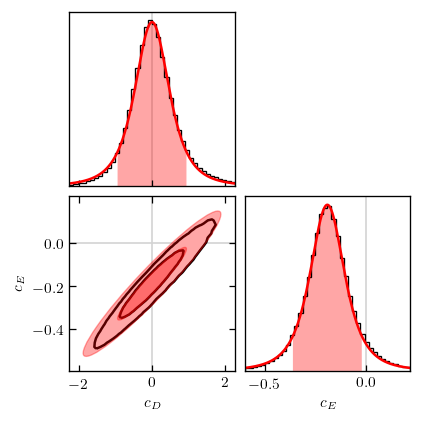

In [35]:
if include_in_emulator:
    suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
else:
    suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'

fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex='col', constrained_layout=True)
fig, axes = pretty_corner(
    data=lec_samples_flat,
    loc=loc,
    scale=scale,
    df=df,
    labels=lec_names_tex,
    quantiles=quantiles_t,
    levels=stdv_levels_2d_t,
    plot_hist=False,
    plot_contour=True,
#     text=samples_description_string,
#     title=suptitle_label,
    axes=axes,
    bins=40,
#     xlabel_pad=0,
    xtick_rotation=0,
    ytick_rotation=0,
    stdv_range=2.4,
)

axes[1, 0].set_xticks([-2, 0, 2])
axes[1, 0].set_yticks([0, -0.2, -0.4])
axes[1, 1].set_xticks([-0.5, 0]);
fig.savefig(join(sample_directory, 'posterior_samples_cd_ce_clean.png'), dpi=700)

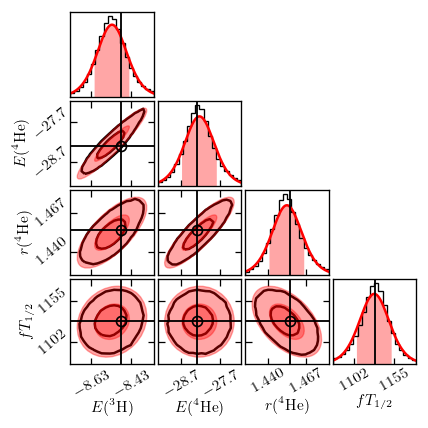

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(3.4, 3.4), sharex='col', constrained_layout=True)
fig, axes = pretty_corner(
    data=predictions_flat,
    loc=loc_obs,
    scale=scale_obs,
    df=df_obs,
    labels=obs_names_tex,
    quantiles=quantiles_t_obs,
    levels=stdv_levels_2d_t_obs,
    plot_hist=False,
    plot_contour=True,
#     text=samples_description_string,
#     title=suptitle_label,
    axes=axes,
    bins=20,
    stdv_range=2.4,
    truths=experiment,
)
for ax in axes.ravel():
    ax.tick_params(axis='y', pad=0.9)
    for tick in ax.get_yticklabels():
        tick.set_verticalalignment("center")
    ax.tick_params(axis='x', pad=1.5)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=1)
    ax.set_xlabel(ax.get_xlabel(), labelpad=1)

fig.set_constrained_layout_pads(w_pad=1.2/72, h_pad=1.2/72, hspace=0, wspace=0);
fig.savefig(join(sample_directory, 'posterior_predictive_samples_clean.png'), dpi=700)

## Create the $\bar c$-$Q$ plot

Part of this is gridded and part is sampled.

In [39]:
from fit3bf.sampling import invchi2

In [40]:
invchi2_prior = invchi2(
    sample_parameters['hyperparameters']['cbar']["degrees_of_freedom"],
    sample_parameters['hyperparameters']['cbar']["scale"]
)
beta_prior = stats.beta(
    sample_parameters['hyperparameters']['Q']["a"],
    sample_parameters['hyperparameters']['Q']["b"]
)

In [41]:
contour_masses = np.array([0] + [1-np.exp(-0.5*r**2) for r in [1, 2]])
contour_masses

array([0.        , 0.39346934, 0.86466472])

In [44]:
cbar_vals = np.linspace(1e-5, 10, 201)
Q_vals = np.linspace(1e-5, 1-1e-5, 101)
log_hyp_prior = trunc_dist.logprior(cbar_vals[:, None], Q_vals)
# Convert from cbar**2 pdf to a pdf that's a function of cbar
hyp_prior_grid = 2*cbar_vals[:, None]*np.exp(log_hyp_prior)
hyp_prior_contours = find_contour_levels(
    hyp_prior_grid,
    levels=contour_masses
)

In [45]:
log_post = np.array([
    trunc_dist.logpdf(cbar_vals, Q_i, y=mean_predictions_trunc, order=hyp["EFT_order"])
    for Q_i in Q_vals
]).T

In [46]:
# Convert from cbar**2 pdf to a pdf that's a function of cbar
hyp_post_grid = 2*cbar_vals[:, None]*np.exp(log_post)
hyp_post_contours = find_contour_levels(
    hyp_post_grid,
    levels=contour_masses
)

In [47]:
hyp_post_contours

array([0.28469924, 2.10185224, 4.254201  ])

In [48]:
def joint_plot(ratio=1, height=3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height), constrained_layout=False)
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
#     fig.tight_layout(h_pad=0, w_pad=0)

    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0, top=1, right=1)

    return fig, ax_joint, ax_marg_x, ax_marg_y

def plot_joint_pdf_gridded(
    x, y, pdf_x, pdf_y, pdf_joint, ax_joint, ax_marg_x,
    ax_marg_y, color, facecolor, zorder=None, filled=False, marg_alpha=1,
    contour_kwargs=None, **kwargs
):
    # Plot contour
    if filled is True:
        ax_joint.contourf(
            x, y, pdf_joint, zorder=zorder, **kwargs
        )
    elif filled is False:
        ax_joint.contour(
            x, y, pdf_joint, zorder=zorder, **kwargs
        )
    elif filled == 'both':
        ax_joint.contourf(
            x, y, pdf_joint, zorder=zorder, **kwargs
        )
        ax_joint.contour(
            x, y, pdf_joint, zorder=zorder, **contour_kwargs
        )

    # Now plot the marginal distributions
    ax_marg_y.plot(pdf_y, y, c=color, lw=1, zorder=zorder)
    ax_marg_y.fill_betweenx(
        y, np.zeros_like(pdf_y),
        pdf_y, facecolor=facecolor, lw=1, zorder=zorder,
        alpha=marg_alpha,
    )
    ax_marg_x.plot(x, pdf_x, c=color, lw=1, zorder=zorder)
    ax_marg_x.fill_between(
        x, np.zeros_like(x),
        pdf_x, facecolor=facecolor, lw=1, zorder=zorder,
        alpha=marg_alpha,
    )
    return ax_joint, ax_marg_x, ax_marg_y

def plot_joint_pdf_histogram(
    data, ax_joint, ax_marg_x,
    ax_marg_y, zorder=None, bins=30, hist_bin_factor_x=1, hist_bin_factor_y=1, **kwargs
):
    from corner import hist2d

    # H, X, Y = np.histogram2d(data[:, i], data[:, j], density=True)
    # print(H.shape, X.shape, Y.shape)
    # ax.contour(X, Y, H, levels=levels, color='k')
    hist2d(
        data[:, 0],
        data[:, 1],
        bins=bins,
        ax=ax_joint,
        plot_density=False,
        plot_contours=True,
        plot_datapoints=False,
        zorder=zorder,
        **kwargs
    )

    # Now plot the marginal distributions
    for i in range(2):
        samples = data[:, i]
        if i == 0:
            ax = ax_marg_x
            orientation = "vertical"
            hist_bin_factor = hist_bin_factor_x
        else:
            ax = ax_marg_y
            orientation = "horizontal"
            hist_bin_factor = hist_bin_factor_y
            
        ax.hist(
            samples,
            bins=int(bins*hist_bin_factor),
#             range=[min_range[i], max_range[i]],
            density=True,
            histtype='step',
            color='k',
            orientation=orientation,
            zorder=zorder,
            # alpha=0.5,
        )
    return ax_joint, ax_marg_x, ax_marg_y

In [49]:
from matplotlib import ticker

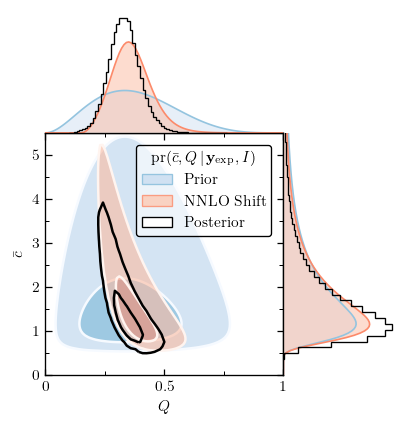

In [50]:
fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=2, height=3.4)

cbar_prior_vals = 2*cbar_vals*trunc_dist.cbar_sq_prior(cbar_vals)
cbar_post_vals = np.trapz(hyp_post_grid, x=Q_vals, axis=-1)

Q_prior_vals = trunc_dist.Q_prior(Q_vals)
Q_post_vals = np.trapz(hyp_post_grid, x=cbar_vals, axis=0)

plot_joint_pdf_histogram(
    hyperparameter_samples_flat[:, ::-1],
    ax_joint, ax_marg_x, ax_marg_y,
    bins=60,
    levels=contour_masses,
    range=[[0,1], [0, 10]],
    zorder=3,
    hist_bin_factor_x=1.0,
    hist_bin_factor_y=6,
);

cmap_prior = mpl.cm.get_cmap("Blues")
cmap_post = mpl.cm.get_cmap("Reds")

# post_light = cmap_post(0.2)
# post_dark = cmap_post(0.4)

post_light = cmap_post(0.25)
post_dark = cmap_post(0.4)
plot_joint_pdf_gridded(
    Q_vals, cbar_vals, Q_prior_vals, cbar_prior_vals, hyp_prior_grid,
    ax_joint, ax_marg_x, ax_marg_y,
    color=cmap_prior(0.4), facecolor=cmap_prior(0.2), filled='both',
    levels=hyp_prior_contours, alpha=0.9,
    colors=[cmap_prior(0.2), cmap_prior(0.4)],
    contour_kwargs=dict(
        colors=[cmap_prior(1), cmap_prior(1)],
        levels=hyp_prior_contours,
    ),
    marg_alpha=0.5,
    zorder=1,
);


plot_joint_pdf_gridded(
    Q_vals, cbar_vals, Q_post_vals, cbar_post_vals, hyp_post_grid,
    ax_joint, ax_marg_x, ax_marg_y,
    color=post_dark, facecolor=post_light,
    filled='both', alpha=0.6,
    levels=hyp_post_contours,
    colors=[post_light, post_dark],
    contour_kwargs=dict(
        colors=[cmap_post(1), cmap_post(1)],
        levels=hyp_post_contours,
    ),
    marg_alpha=0.5,
    zorder=1,
);

proxy = [
    plt.Rectangle((0,0), 1, 1, fc=cmap_prior(0.2), alpha=0.99, ec=cmap_prior(0.4)),
    plt.Rectangle((0,0), 1, 1, fc=cmap_post(0.2), alpha=0.8, ec=cmap_post(0.4)),
    plt.Rectangle((0,0), 1, 1, fc='w', ec='k'),
]

ax_joint.legend(
    proxy, ["Prior", "NNLO Shift", "Posterior"],
    loc='upper right', title=r'pr($\bar c, Q \,|\, \mathbf{y}_{\mathrm{exp}}, I$)'
)
ax_joint.set_ylabel(fr"$\bar c$")
ax_joint.set_xlabel(fr"$Q$")
ax_joint.set_xlim(0., 1)
ax_joint.set_ylim(0, 5.5)
ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax_joint.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_joint.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax_joint.set_xticks([0, 0.5, 1])
ax_joint.set_xticklabels([0, 0.5, 1])

ax_joint.margins(x=0, y=0.)
ax_marg_x.set_ylim(bottom=0)
ax_marg_y.set_xlim(left=0);
fig.savefig(join(sample_directory, 'hyperparameter_samples_clean.png'), dpi=700)

# OLD STUFF BELOW


---

In [ ]:
assert False  # Stop a "run all" from continuing past this point

In [37]:
# fig, axes = plt.subplots(n_lecs, n_lecs, figsize=(3.4, 3.4))
# fig = corner.corner(
#     lec_samples_flat, labels=lec_names_tex,
#     bins=30,
# #     quantiles=quantiles_1d,
#     quantiles=quantiles_t,
#     hist_bin_factor=2,
#     show_titles=True, title_kwargs={"fontsize": 10},
# #     levels=stdv_levels_2d,
#     levels=stdv_levels_2d_t,
#     fig=fig,
#     range=[0.99] * n_lecs,
#     hist_kwargs={'density': True}
# )

# for (i, j), ax in np.ndenumerate(axes):
#     if i >= j:
#         ax.axvline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
#         if i == j:
#             plot_gaussian_approximation(lec_samples_flat[:, i], ax)
#             plot_student_t_from_params(
#                 lec_samples_flat[:, i], df, loc[i], np.sqrt(scale[i,i]),
#                 ax=ax, c='r', lw=1.5, ls=':'
#             )
#         if i != j:
#             for stdv in [1, 2]:
#                 pass
# #                 confidence_ellipse(
# #                     lec_samples_flat[:, j], lec_samples_flat[:, i],
# #                     ax, n_std=stdv, edgecolor='r', zorder=10
# #                 )
#                 confidence_ellipse_student_t_from_params(
#                     df=df, mean=loc, scale=scale, ax=ax,
#                     n_std=stdv, edgecolor='r', zorder=10
#                 )
#             ax.axhline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
#     else:
#         ax.text(
#             0.05, 1.06, s=samples_description_string, ma='left', va='top',
#             bbox=dict(facecolor='w', boxstyle='round')
#         )
        

# if include_in_emulator:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
# else:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'
# fig.suptitle(suptitle_label, y=1.06, fontsize=11)
# # bbox_inches = 'tight' will mess up figure size but will get the title to fit.
# # Fix this later.
# fig.savefig(join(sample_directory, 'posterior_samples_cd_ce.pdf'), bbox_inches='tight')

In [ ]:

# fig = corner.corner(
#     lec_samples_flat, labels=lec_names_tex,
#     bins=50,
# #     quantiles=quantiles_t_obs,
#     hist_bin_factor=3,
#     show_titles=True, title_kwargs={"fontsize": 9},
# #     levels=stdv_levels_2d_t_obs,
# #     fig=fig,
# #     range=[1.1] * lec_samples_flat.shape[-1],
# #     truths=experiment,
#     hist_kwargs={'density': True}
# )
# fig.axes[2].set_xlim(-2, 2)

In [ ]:
# if include_in_emulator:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
# else:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'

# pretty_corner(
#     data=lec_samples_flat,
#     loc=loc,
#     scale=scale,
#     df=df,
#     labels=lec_names_tex,
#     quantiles=quantiles_t,
#     levels=stdv_levels_2d_t,
#     plot_hist=True,
#     text=samples_description_string,
#     title=suptitle_label
# );

In [ ]:
# fig = corner.corner(
#     predictions_flat, labels=obs_names_tex,
#     bins=50,
#     quantiles=quantiles_t_obs,
#     hist_bin_factor=3,
#     show_titles=True, title_kwargs={"fontsize": 9},
#     levels=stdv_levels_2d_t_obs,
# #     fig=fig,
#     range=[0.995] * predictions_flat.shape[-1],
#     truths=experiment,
#     hist_kwargs={'density': True}
# )

In [ ]:
fig, axes = plt.subplots(n_lecs, n_lecs, figsize=(3.4, 3.4))
fig = corner.corner(
    hyperparameter_samples_flat,
    labels=hyperparameter_names_tex,
    bins=30,
#     quantiles=quantiles_1d,
#     quantiles=quantiles_t,
    hist_bin_factor=2,
    show_titles=True,
    title_kwargs={"fontsize": 10},
    levels=np.array([0.68, 0.95]),
#     levels=stdv_levels_2d,
#     levels=stdv_levels_2d_t,
    fig=fig,
#     range=[0.99] * 2,
    hist_kwargs={'density': True},
    plot_datapoints=False,
    range=[[0, 8], 0.995]
)

cbar_max = 8

for (i, j), ax in np.ndenumerate(axes):
    if i >= j:
        if i == j:
            samples_ordered = np.sort(hyperparameter_samples_flat[:, i])
            if hyperparameter_names[i] == 'cbar':
#                 samples_ordered = samples_ordered[samples_ordered <= cbar_max]
                # Convert from cbar^2 scale to cbar scale
#                 ax.plot(samples_ordered, 2*samples_ordered*invchi2_prior.pdf(samples_ordered**2))
#                 ax.plot(samples_ordered, 2*samples_ordered*trunc_dist.cbar_sq_prior(samples_ordered))
                ax.plot(samples_ordered, 2*samples_ordered*trunc_dist.cbar_sq_prior(samples_ordered), label='Prior')
                ax.plot(cbar_vals, np.trapz(hyp_post_grid, x=Q_vals, axis=-1), c='C1', label="Post.\ Trunc")
            elif hyperparameter_names[i] == 'Q':
#                 ax.plot(samples_ordered, beta_prior.pdf(samples_ordered))
                ax.plot(samples_ordered, trunc_dist.Q_prior(samples_ordered))
                ax.plot(Q_vals, np.trapz(hyp_post_grid, x=cbar_vals, axis=0), c='C1')
            if i == 0:
                ax.plot([], [], c='k', label="Posterior Fit")
                ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
        if i != j:
            ax.contour(cbar_vals, Q_vals, hyp_prior_grid.T, levels=hyp_prior_contours, colors='C0')
            ax.contour(cbar_vals, Q_vals, hyp_post_grid.T, levels=hyp_post_contours, colors='C1')

fig.savefig(join(sample_directory, 'hyperparameter_samples_cd_ce.pdf'))

In [ ]:
hyperparameter_samples_flat_cbar_sq = hyperparameter_samples_flat.copy()
hyperparameter_samples_flat_cbar_sq[:, 0] **= 2


fig, axes = plt.subplots(n_lecs, n_lecs, figsize=(3.4, 3.4))
fig = corner.corner(
    hyperparameter_samples_flat_cbar_sq, labels=hyperparameter_names_tex,
    bins=30,
#     quantiles=quantiles_1d,
#     quantiles=quantiles_t,
    hist_bin_factor=2,
    show_titles=True, title_kwargs={"fontsize": 10},
    levels=np.array([0.68, 0.95]),
#     levels=stdv_levels_2d,
#     levels=stdv_levels_2d_t,
    fig=fig,
    range=[0.995] * n_lecs,
    hist_kwargs={'density': True}
)


for (i, j), ax in np.ndenumerate(axes):
    if i >= j:
        if i == j:
            samples_ordered = np.sort(hyperparameter_samples_flat_cbar_sq[:, i])
            if hyperparameter_names[i] == 'cbar':
                # Convert from cbar^2 scale to cbar scale
#                 ax.plot(samples_ordered, 2*samples_ordered*invchi2_prior.pdf(samples_ordered**2))
#                 ax.plot(samples_ordered, 2*samples_ordered*trunc_dist.cbar_sq_prior(samples_ordered))
                ax.plot(samples_ordered, trunc_dist.cbar_sq_prior(np.sqrt(samples_ordered)))
                ax.plot(cbar_vals**2, np.trapz(hyp_post_grid, x=Q_vals, axis=-1), c='C1')
            elif hyperparameter_names[i] == 'Q':
#                 ax.plot(samples_ordered, beta_prior.pdf(samples_ordered))
                ax.plot(samples_ordered, trunc_dist.Q_prior(samples_ordered))
                ax.plot(Q_vals, np.trapz(hyp_post_grid, x=cbar_vals**2, axis=0), c='C1')
        if i != j:
            ax.contour(cbar_vals**2, Q_vals, hyp_prior_grid.T, levels=hyp_prior_contours_cbar_sq, colors='C0')
            ax.contour(cbar_vals**2, Q_vals, hyp_post_grid.T, levels=hyp_post_contours_cbar_sq, colors='C1')
        

# if use_gradients:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
# else:
#     suptitle_label = r'pr($c_D, c_E \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'
fig.suptitle("Hyperparameter posteriors vs priors", y=1.06, fontsize=11)
# bbox_inches = 'tight' will mess up figure size but will get the title to fit.
# Fix this later.
# fig.savefig(join(sample_directory, 'hyperparameter_samples_cd_ce.pdf'), bbox_inches='tight')

In [ ]:
# fig, axes = plt.subplots(4, 4, figsize=(6, 5))
# fig = corner.corner(
#     samples_flat[:, ::-1], labels=lec_and_hyp_names_tex[::-1],
#     bins=30,
# #     quantiles=quantiles_1d,
# #     quantiles=quantiles_t,
#     hist_bin_factor=2,
#     show_titles=True, title_kwargs={"fontsize": 10},
# #     levels=stdv_levels_2d,
# #     levels=stdv_levels_2d_t,
#     fig=fig,
#     range=[0.995] * 4,
#     hist_kwargs={'density': True}
# )
# axes[0, -1].text(
#     0.05, 1.06, s=samples_description_string, ma='left', va='top',
#     bbox=dict(facecolor='w', boxstyle='round')
# )

In [ ]:
fig, axes = plt.subplots(n_obs, n_obs, figsize=(max(4, 6*n_obs/4), max(3, 5*n_obs/4)))
# fig, axes = plt.subplots(n_obs, n_obs, figsize=(4, 3))
fig = corner.corner(
    predictions_flat, labels=obs_names_tex,
    bins=50,
    quantiles=quantiles_t_obs,
    hist_bin_factor=3,
    show_titles=True, title_kwargs={"fontsize": 9},
    levels=stdv_levels_2d_t_obs,
    fig=fig,
    range=[0.995] * predictions_flat.shape[-1],
    truths=experiment,
    hist_kwargs={'density': True}
)

# for (i, j), ax in np.ndenumerate(axes):
#     if i >= j:
#         ax.axvline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
#         if i == j:
#             plot_gaussian_approximation(predictions_flat[:, i], ax)
#             plot_student_t_from_params(
#                 predictions_flat[:, i], df, loc_obs[i], np.sqrt(scale_obs[i,i]),
#                 ax=ax, c='r', lw=1.5, ls=':'
#             )
#         if i != j:
#             for stdv in [1, 2]:
#                 pass
# #                 confidence_ellipse(
# #                     lec_samples_flat[:, j], lec_samples_flat[:, i],
# #                     ax, n_std=stdv, edgecolor='r', zorder=10
# #                 )
#                 confidence_ellipse_student_t_from_params(
#                     df=df, mean=loc_obs[[j, i]],
#                     scale=scale_obs[np.array([j, i])[:, None], [j, i]],
#                     ax=ax,
#                     n_std=stdv, edgecolor='r', zorder=10
#                 )
#             ax.axhline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
#     else:
#         pass

axes[0, -1].text(
    0.05, 1.06, s=samples_description_string, ma='left', va='top',
    bbox=dict(facecolor='w', boxstyle='round')
)
# fig.savefig(join(sample_directory, 'posterior_predictive_samples.pdf'))

In [ ]:
# fig, axes = plt.subplots(n_obs, n_obs, figsize=(max(4, 6*n_obs/4), max(3, 5*n_obs/4)))
fig, axes = plt.subplots(n_obs, n_obs, figsize=(3.4, 3.4))
# fig, axes = plt.subplots(n_obs, n_obs, figsize=(4, 3))
fig = corner.corner(
    predictions_flat, labels=obs_names_tex,
    bins=50,
    quantiles=quantiles_1d,
    hist_bin_factor=3,
    show_titles=False,
    title_kwargs={"fontsize": 9},
    levels=stdv_levels_2d,
    fig=fig,
    range=[0.998] * predictions_flat.shape[-1],
    truths=experiment,
    labelpad=0.25,
)
# axes[0, -2].text(
#     0.05, 1.06, s=samples_description_string, ma='left', va='top',
#     bbox=dict(facecolor='w', boxstyle='round')
# )
axes[0, -2].text(
    0.4, 1.06, s=samples_description_string, ma='left', va='top',
    bbox=dict(facecolor='w', boxstyle='round')
)
# fig.subplots_adjust(
#     left=.1, bottom=0.1 
# )
fig.savefig(join(sample_directory, 'posterior_predictive_samples.pdf'), bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(n_post_lecs, n_post_lecs, figsize=(11, 8))
fig = corner.corner(
    post_lec_samples_flat, labels=post_lec_names_tex,
    bins=20,
#     quantiles=quantiles_1d,
#     quantiles=quantiles_t,
    hist_bin_factor=2,
    show_titles=True,
    title_kwargs={"fontsize": 5},
#     levels=stdv_levels_2d,
#     levels=stdv_levels_2d_t,
    fig=fig,
    range=[0.995] * n_post_lecs,
    hist_kwargs={'density': True},
    labelpad=0.4
)

for (i, j), ax in np.ndenumerate(axes):
    if i >= j:
        ax.axvline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
        if i == j:
            plot_gaussian_from_params(
                post_lec_samples_flat[:, i],
                nn_lecs_loc[i], np.sqrt(nn_lecs_cov[i,i]),
                ax=ax
            )
        if i != j:
            for stdv in [1, 2]:
                pass
                confidence_ellipse_mean_cov(
                    nn_lecs_loc[[j, i]], nn_lecs_cov[np.array([j, i])[:, None], [j, i]],
                    ax, n_std=stdv, edgecolor='r', zorder=10
                )
            ax.axhline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)

            
axes[2, -3].text(
    0.05, 1.06, s=samples_description_string, ma='left', va='top',
    bbox=dict(facecolor='w', boxstyle='round')
)

if include_in_emulator:
    suptitle_label = r'pr($c_{NN} \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
else:
    suptitle_label = r'pr($c_{NN} \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'
fig.suptitle(suptitle_label, y=1.06, fontsize=11)
# fig.tight_layout()
# bbox_inches = 'tight' will mess up figure size but will get the title to fit.
# Fix this later.
fig.savefig(join(sample_directory, 'posterior_samples_nn_lecs.pdf'), bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(n_all_lecs, n_all_lecs, figsize=(11, 8))
fig = corner.corner(
    all_lec_samples_flat, labels=all_lec_names_tex,
    bins=20,
#     quantiles=quantiles_1d,
#     quantiles=quantiles_t,
    hist_bin_factor=2,
    show_titles=True,
    title_kwargs={"fontsize": 5},
#     levels=stdv_levels_2d,
#     levels=stdv_levels_2d_t,
    fig=fig,
    range=[0.995] * n_all_lecs,
    hist_kwargs={'density': True},
    labelpad=0.4
)

# for (i, j), ax in np.ndenumerate(axes):
#     if i >= j:
#         ax.axvline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)
#         if i == j:
#             plot_gaussian_from_params(
#                 post_lec_samples_flat[:, i],
#                 nn_lecs_loc[i], np.sqrt(nn_lecs_cov[i,i]),
#                 ax=ax
#             )
#         if i != j:
#             for stdv in [1, 2]:
#                 pass
#                 confidence_ellipse_mean_cov(
#                     nn_lecs_loc[[j, i]], nn_lecs_cov[np.array([j, i])[:, None], [j, i]],
#                     ax, n_std=stdv, edgecolor='r', zorder=10
#                 )
#             ax.axhline(0, 0, 1, c='lightgrey', lw=1, zorder=-10)

            
axes[2, -3].text(
    0.05, 1.06, s=samples_description_string, ma='left', va='top',
    bbox=dict(facecolor='w', boxstyle='round')
)

if include_in_emulator:
    suptitle_label = r'pr($c_{NN+3BF} \, | \, \mathbf{y}_{\rm{exp}}, \Sigma_{{nn}}, I$)'
else:
    suptitle_label = r'pr($c_{NN+3BF} \, | \, \mathbf{y}_{\rm{exp}}, \vec{a}_{{nn}}, I$)'
fig.suptitle(suptitle_label, y=1.06, fontsize=11)
# fig.tight_layout()
# bbox_inches = 'tight' will mess up figure size but will get the title to fit.
# Fix this later.
fig.savefig(join(sample_directory, 'posterior_samples_nn_and_3bf_lecs.pdf'), bbox_inches='tight')

# Digression on integrating out Q (OLD!!)

In [ ]:
def integrate_student_t_scale(t, df, prior):
    def _integrand(scale, t_i):
        return stats.t.pdf(t_i, df=df, scale=scale) * prior(scale)
    integral = []
    for t_i in t:
        integral_i, err = integrate.quad(_integrand, a=0, b=np.inf, args=(t_i))
        integral.append(integral_i)
    return np.array(integral)

In [ ]:
def scale_invariant_prior(s):
    return 1.0 / s ** 2

In [ ]:
from fit3bf.sampling import invchi2

In [ ]:
def get_invchi2_dist(df, scale):
    return stats.invgamma(df/2.0, scale=df * scale ** 2 / 2)

In [ ]:
tt = np.linspace(-5, 5, 201)
# integrated_t = integrate_student_t_scale(tt, df=5, prior=stats.beta(a=30.65, b=50).pdf)
# integrated_t = integrate_student_t_scale(tt, df=5, prior=get_invchi2_dist(10, scale=1).pdf)
# integrated_t = integrate_student_t_scale(tt, df=5, prior=get_invchi2_dist(100, scale=1).pdf)
integrated_t = integrate_student_t_scale(tt, df=5, prior=lambda x: 1/x**2)

# integrated_t_5 = integrate_student_t_scale(tt, df=5, prior=lambda x: 1/x**3)
# integrated_t_50 = integrate_student_t_scale(tt, df=50, prior=lambda x: 1/x**2)
# integrated_t_1 = integrate_student_t_scale(tt, df=3, prior=lambda x: 1/x**2)

In [ ]:
plt.plot(tt, get_invchi2_dist(1, scale=1).pdf(tt))

In [ ]:
def norm_t(t, df, scale):
    pdf = stats.t.pdf(tt, df=df, scale=scale)
    return pdf / pdf.max()

In [ ]:
# plt.plot(tt, integrated_t/integrated_t.max())
# plt.plot(tt, norm_t(tt, df=4, scale=0.37), ls='--')

In [ ]:
plt.plot(tt, integrated_t/integrated_t.max())
plt.plot(tt, norm_t(tt, df=4, scale=0.37), ls='--')